# HDB Resale Price Prediction - PyTorch Neural Network

This notebook implements a deep learning model to predict Singapore HDB resale prices using PyTorch with categorical embeddings and continuous features.

## Project Overview
- **Dataset**: 213,883 HDB transactions (2017-2025)
- **Approach**: Neural network with categorical embeddings
- **Goal**: Predict resale prices with high accuracy
- **Architecture**: Deep learning with custom PyTorch model

## Setup and Imports

First, let's import all necessary libraries and mount Google Drive to access our preprocessed data.

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Device Configuration

We'll automatically detect the best available compute device (GPU/CPU) for training our model.


In [28]:
def get_device():
  if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA GPU: {torch.cuda.get_device_name()}")
  elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU (MPS)")
  else:
    device = torch.device('cpu')
    print("Using CPU")
  return device

## Data Loading

Load our preprocessed numpy arrays and convert them to PyTorch tensors.

**Key Features**:
- `.long()` for categorical indices (embeddings expect integers)
- `.float()` for continuous values and targets
- `torch.from_numpy()` for memory-efficient tensor creation

**Expected Output**:
- Training: ~143K samples
- Validation: ~26K samples  
- Test: ~28K samples
- 4 categorical + 5 continuous features

In [29]:
# Define the base path
base_path = '/content/drive/My Drive/HDB_resale_project/preprocessed_data/'

def load_preprocessed_data(base_path):

  print("Loading preprocessed data...")

  # Training data
  train_cat = torch.from_numpy(np.load(f'{base_path}train/train_cat.npy')).long()
  train_cont = torch.from_numpy(np.load(f'{base_path}train/train_cont.npy')).float()
  train_target = torch.from_numpy(np.load(f'{base_path}train/train_target.npy')).float()

  # Validation data
  val_cat = torch.from_numpy(np.load(f'{base_path}val/val_cat.npy')).long()
  val_cont = torch.from_numpy(np.load(f'{base_path}val/val_cont.npy')).float()
  val_target = torch.from_numpy(np.load(f'{base_path}val/val_target.npy')).float()

  # Test data
  test_cat = torch.from_numpy(np.load(f'{base_path}test/test_cat.npy')).long()
  test_cont = torch.from_numpy(np.load(f'{base_path}test/test_cont.npy')).float()
  test_target = torch.from_numpy(np.load(f'{base_path}test/test_target.npy')).float()

  print(f"Training samples: {train_cat.shape[0]:,}")
  print(f"Validation samples: {val_cat.shape[0]:,}")
  print(f"Test samples: {test_cat.shape[0]:,}")
  print(f"Categorical features: {train_cat.shape[1]}")
  print(f"Continuous features: {train_cont.shape[1]}")

  return {
      'train': (train_cat, train_cont, train_target),
      'val': (val_cat, val_cont, val_target),
      'test': (test_cat, test_cont, test_target)
  }

##  Data Pipeline Setup

Create PyTorch DataLoaders for efficient batch processing during training.

**Why DataLoaders?**:
- **Batching**: Process 512 samples at once (GPU efficiency)
- **Shuffling**: Randomize training data each epoch
- **Parallel Loading**: Multi-worker data preparation
- **Memory Management**: Stream data without loading everything

In [30]:
def create_data_loaders(data_dict, batch_size = 512, num_workers = 2):

  loaders = {}
  for split, (cat, cont, target) in data_dict.items():
    dataset = TensorDataset(cat, cont, target)
    shuffle = (split == 'train')

    loader = DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle = shuffle,
        num_workers = num_workers,
        pin_memory = True,
        drop_last = False
    )
    loaders[split] = loader
    print(f"{split.capitalize()} loader: {len(loader)} batches")

  return loaders


##  Model Architecture

Our neural network combines categorical embeddings with continuous features.

### Architecture Overview:
**Input Features:**
- Categorical → Embeddings: [Town, Flat Type, Storey, Model]
-  Continuous: [Area, Lease, Age, Year, Month]
-  Combined → Dense Layers → Price Prediction


**Why Embeddings?**
- Convert categories to dense vectors (vs sparse one-hot)
- Learn relationships: "Similar towns → Similar embeddings"
- More efficient and expressive than traditional encoding

### Network Structure:
- **Input**: 43 embedding dimensions + 5 continuous = 48 total features
- **Hidden**: [128 → 64 → 32] with ReLU activation and dropout
- **Output**: Single price prediction

In [31]:
class HDBPricePredictor(nn.Module):
  def __init__(self, embedding_sizes, n_continuous, hidden_sizes=[64, 32], dropout_rate=0.2):
    super().__init__()

    # Store architecture info for debugging
    self.embedding_sizes = embedding_sizes
    self.n_continuous = n_continuous
    self.hidden_sizes = hidden_sizes
    self.dropout_rate = dropout_rate

    self.embeddings = nn.ModuleList([
        nn.Embedding(categories, size) for categories, size in embedding_sizes
    ])

    total_embedding_dim = sum(size for _, size in embedding_sizes)
    input_size = total_embedding_dim + n_continuous

    layers = []
    prev_size = input_size

    for hidden_size in self.hidden_sizes:
      layers.extend([
        nn.Linear(prev_size, hidden_size),
        nn.ReLU(),
        nn.Dropout(self.dropout_rate)
      ])
      prev_size = hidden_size

    layers.append(nn.Linear(prev_size, 1))

    self.main_network = nn.Sequential(*layers)

    print(f"Model created:")
    print(f"  - Embedding dimensions: {total_embedding_dim}")
    print(f"  - Continuous features: {n_continuous}")
    print(f"  - Total input size: {input_size}")
    print(f"  - Hidden layers: {hidden_sizes}")
    print(f"  - Dropout rate: {dropout_rate}")

  def forward(self, categorical, continuous):
    # 1. Get embeddings for each categorical feature
    embedded_features = []
    for i, embedding_layer in enumerate(self.embeddings):
      embedded = embedding_layer(categorical[:, i])
      embedded_features.append(embedded)

    # 2. Concatenate all embeddings
    if embedded_features:
      embedded_concat = torch.cat(embedded_features, dim=1)
      # 3. Concatenate with continuous features
      combined = torch.cat([embedded_concat, continuous], dim=1)
    else:
      combined = continuous

    # 4. Pass through main network
    output = self.main_network(combined)

    return output.squeeze()  # Remove extra dimension

##  Evaluation Metrics

Define comprehensive metrics to evaluate model performance.

**Metrics Explained**:
- **RMSE**: Root Mean Square Error (penalizes large errors)
- **MAE**: Mean Absolute Error (robust to outliers)
- **MAPE**: Mean Absolute Percentage Error (relative performance)
- **R²**: Coefficient of determination (variance explained)

In [32]:
def calculate_metrics(y_true, y_pred, split_name=""):
    """
    Calculate comprehensive regression metrics.

    Learning Points:
    - RMSE: Root Mean Square Error (penalizes large errors more)
    - MAE: Mean Absolute Error (robust to outliers)
    - MAPE: Mean Absolute Percentage Error (relative error)
    - R²: Coefficient of determination (variance explained)
    """
    y_true_np = y_true.cpu().numpy() if torch.is_tensor(y_true) else y_true
    y_pred_np = y_pred.cpu().numpy() if torch.is_tensor(y_pred) else y_pred

    rmse = np.sqrt(mean_squared_error(y_true_np, y_pred_np))
    mae = mean_absolute_error(y_true_np, y_pred_np)

    # MAPE (handle division by zero)
    mape = np.mean(np.abs((y_true_np - y_pred_np) / np.maximum(y_true_np, 1))) * 100

    r2 = r2_score(y_true_np, y_pred_np)

    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2
    }

    if split_name:
        print(f"\n{split_name} Metrics:")
        for metric, value in metrics.items():
            if metric in ['RMSE', 'MAE']:
                print(f"  {metric}: ${value:,.0f}")
            elif metric == 'MAPE':
                print(f"  {metric}: {value:.2f}%")
            else:
                print(f"  {metric}: {value:.4f}")

    return metrics

##  Training Functions

Implement the core training and validation loops.

### Training Epoch Function:
**The 5-Step Training Cycle**:
1. `optimizer.zero_grad()` - Clear previous gradients
2. `model(inputs)` - Forward pass through network
3. `criterion(pred, target)` - Calculate loss
4. `loss.backward()` - Compute gradients (backpropagation)
5. `optimizer.step()` - Update model weights

### Validation Function:
- **No gradient calculation**: `torch.inference_mode()` for efficiency
- **No weight updates**: Only evaluate performance
- **Consistent results**: `model.eval()` disables dropout

In [33]:
def train_epoch(model, train_loader, optimizer, criterion, device):

  model.train()
  total_loss = 0
  num_batches = 0

  for cat_batch, cont_batch, target_batch in train_loader:
    # Move data to device (GPU/MPS/CPU)
    cat_batch = cat_batch.to(device)
    cont_batch = cont_batch.to(device)
    target_batch = target_batch.to(device)

    # Zero gradients from previous iteration
    optimizer.zero_grad()

    # Forward pass
    predictions = model(cat_batch, cont_batch)

    # Calculate loss
    loss = criterion(predictions, target_batch)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    total_loss += loss.item()
    num_batches += 1

  return total_loss / num_batches

In [34]:
def validate(model, val_loader, criterion, device):
  model.eval()
  total_loss = 0
  all_predictions = []
  all_targets = []


  with torch.inference_mode():  # Don't calculate gradients during validation
    for cat_batch, cont_batch, target_batch in val_loader:
        cat_batch = cat_batch.to(device)
        cont_batch = cont_batch.to(device)
        target_batch = target_batch.to(device)

        predictions = model(cat_batch, cont_batch)
        loss = criterion(predictions, target_batch)

        total_loss += loss.item()
        all_predictions.append(predictions.cpu())
        all_targets.append(target_batch.cpu())

  # Concatenate all batches
  all_predictions = torch.cat(all_predictions)
  all_targets = torch.cat(all_targets)

  return total_loss / len(val_loader), all_predictions, all_targets

##  Complete Training Loop

Professional training pipeline with early stopping, learning rate scheduling, and model checkpointing.

**Key Features**:
- **Early Stopping**: Prevents overfitting by stopping when validation stops improving
- **Learning Rate Scheduler**: Reduces LR when validation plateaus
- **Model Checkpointing**: Saves best model weights automatically
- **Comprehensive Tracking**: Monitor all metrics during training

**Training Strategy**:
- Start with LR = 0.01 for fast initial learning
- Reduce LR when validation plateaus (0.01 → 0.005 → 0.0025...)
- Stop training if no improvement for 15 epochs

In [35]:
def train_model(model, train_loader, val_loader, epochs=100, lr=0.001, patience=10):
  device = next(model.parameters()).device  # Get model's device

  # Initialize optimizer and loss function
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # L2 regularization
  criterion = nn.MSELoss()

  # Learning rate scheduler (reduce when validation plateaus)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(
      optimizer, mode='min', factor=0.5, patience=patience//2
  )

  # Training tracking
  train_losses = []
  val_losses = []
  val_rmses = []
  best_val_loss = float('inf')
  patience_counter = 0
  best_model_state = None

  print(f"\nStarting training on {device}")
  print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

  for epoch in range(epochs):
    # Training phase
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)

    # Validation phase
    val_loss, val_predictions, val_targets = validate(model, val_loader, criterion, device)

    # Calculate validation RMSE
    val_rmse = np.sqrt(val_loss)  # Since we're using MSE loss

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Track metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_rmses.append(val_rmse)

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()  # Save best model
    else:
        patience_counter += 1

    # Print progress
    current_lr = optimizer.param_groups[0]['lr']
    if epoch % 10 == 0 or epoch < 10:
        print(f"Epoch {epoch:3d}: Train Loss: {train_loss:.6f}, "
              f"Val Loss: {val_loss:.6f}, Val RMSE: ${val_rmse:,.0f}, LR: {current_lr:.6f}")

    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch}")
        print(f"Best validation loss: {best_val_loss:.6f}")
        break

  # Load best model state
  if best_model_state is not None:
      model.load_state_dict(best_model_state)
      print("Loaded best model weights")

  return {
      'train_losses': train_losses,
      'val_losses': val_losses,
      'val_rmses': val_rmses,
      'best_val_loss': best_val_loss
  }

## Main Training Pipeline

Run the complete training pipeline with optimized hyperparameters.

**Configuration**:
- **Architecture**: [128, 64, 32] hidden layers (deeper than baseline)
- **Embeddings**: Larger embedding dimensions for better representation
- **Batch Size**: 512 (optimal for T4 GPU)
- **Learning Rate**: 0.01 with adaptive scheduling
- **Regularization**: Dropout 0.2 + L2 weight decay

**Expected Training Time**: ~5-10 minutes on T4 GPU

In [36]:
def main():

    # Configuration - Easy to experiment with!
    BASE_PATH = '/content/drive/My Drive/HDB_resale_project/preprocessed_data/'
    BATCH_SIZE = 512
    EPOCHS = 1000
    LEARNING_RATE = 0.01
    PATIENCE = 15

    # Your embedding sizes from preprocessing
    # Format: [(num_categories, embedding_dim), ...]
    EMBEDDING_SIZES = [
        (26, 15),  # town
        (7, 6),    # flat_type
        (17, 10),   # storey_range
        (21, 12)    # flat_model
    ]
    N_CONTINUOUS = 5  # Your continuous features count

    print("=== HDB Resale Price Prediction with PyTorch ===")

    # 1. Setup device
    device = get_device()

    # 2. Load data
    data_dict = load_preprocessed_data(BASE_PATH)

    # 3. Create data loaders
    loaders = create_data_loaders(data_dict, batch_size=BATCH_SIZE)

    # 4. Initialize model
    model = HDBPricePredictor(
        embedding_sizes=EMBEDDING_SIZES,
        n_continuous=N_CONTINUOUS,
        hidden_sizes=[128, 64, 32],  # Experiment with [128, 64, 32] or [64, 64]
        dropout_rate=0.2
    ).to(device)

    # 5. Train model
    history = train_model(
        model=model,
        train_loader=loaders['train'],
        val_loader=loaders['val'],
        epochs=EPOCHS,
        lr=LEARNING_RATE,
        patience=PATIENCE
    )

    # 6. Final evaluation
    print("\n" + "="*50)
    print("FINAL EVALUATION")
    print("="*50)

    # Validation metrics
    _, val_pred, val_true = validate(model, loaders['val'], nn.MSELoss(), device)
    val_metrics = calculate_metrics(val_true, val_pred, "Validation")

    # Test metrics
    _, test_pred, test_true = validate(model, loaders['test'], nn.MSELoss(), device)
    test_metrics = calculate_metrics(test_true, test_pred, "Test")

    print(f"\nTraining completed! Best validation loss: ${np.sqrt(history['best_val_loss']):,.0f}")

    return model, history, (val_pred, val_true), (test_pred, test_true)

In [24]:
model, history, (val_pred, val_true), (test_pred, test_true) = main()

=== HDB Resale Price Prediction with PyTorch ===
Using CUDA GPU: Tesla T4
Loading preprocessed data...
Training samples: 143,396
Validation samples: 25,754
Test samples: 27,833
Categorical features: 4
Continuous features: 5
Train loader: 281 batches
Val loader: 51 batches
Test loader: 55 batches
Model created:
  - Embedding dimensions: 43
  - Continuous features: 5
  - Total input size: 48
  - Hidden layers: [128, 64, 32]
  - Dropout rate: 0.2

Starting training on cuda:0
Model parameters: 17,495
Epoch   0: Train Loss: 48667950644.839859, Val Loss: 7701903269.647058, Val RMSE: $87,760, LR: 0.010000
Epoch   1: Train Loss: 9358265429.637011, Val Loss: 7873338729.411765, Val RMSE: $88,732, LR: 0.010000
Epoch   2: Train Loss: 9285947962.306049, Val Loss: 7552147375.686275, Val RMSE: $86,903, LR: 0.010000
Epoch   3: Train Loss: 9214939888.512455, Val Loss: 5356269171.450980, Val RMSE: $73,187, LR: 0.010000
Epoch   4: Train Loss: 9263663145.907473, Val Loss: 6433401469.490196, Val RMSE: $80,

## Training Results Analysis

### Understanding the Output:

**Loss Values**: Don't be alarmed by large numbers (e.g., 2.4 billion)!
- Loss = MSE (Mean Squared Error) = average of (error²)
- Price errors squared create large numbers
- **Focus on RMSE**: √(loss) gives interpretable error in dollars

**Performance Interpretation**:
- **R² = 0.90**: Model explains 90% of price variance (excellent!)
- **RMSE = ~$59K**: Average prediction error on `$500K+` properties
- **MAPE = 8%**: Predictions typically within 8% of actual prices

**Industry Benchmarks**:
- R² > 0.85: Excellent ← **Our model achieved this!**
- R² 0.75-0.85: Good
- R² < 0.75: Needs improvement

In [25]:
def plot_training_curves(history):
  """Plot training progress - great for understanding model behavior!"""
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  epochs = range(len(history['train_losses']))

  # Loss curves
  ax1.plot(epochs, history['train_losses'], 'b-', label='Training Loss')
  ax1.plot(epochs, history['val_losses'], 'r-', label='Validation Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.set_title('Training and Validation Loss')
  ax1.legend()
  ax1.grid(True)

  # RMSE curve
  ax2.plot(epochs, [np.sqrt(loss) for loss in history['train_losses']], 'b-', label='Training RMSE')
  ax2.plot(epochs, history['val_rmses'], 'r-', label='Validation RMSE')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('RMSE ($)')
  ax2.set_title('RMSE Over Time')
  ax2.legend()
  ax2.grid(True)

  plt.tight_layout()
  plt.show()

def plot_predictions(y_true, y_pred, split_name=""):
  """Plot predicted vs actual prices - see how well your model works!"""
  plt.figure(figsize=(10, 8))

  # Convert to numpy if needed
  y_true_np = y_true.cpu().numpy() if torch.is_tensor(y_true) else y_true
  y_pred_np = y_pred.cpu().numpy() if torch.is_tensor(y_pred) else y_pred

  plt.scatter(y_true_np, y_pred_np, alpha=0.5)
  plt.plot([y_true_np.min(), y_true_np.max()], [y_true_np.min(), y_true_np.max()], 'r--', lw=2)
  plt.xlabel('Actual Price ($)')
  plt.ylabel('Predicted Price ($)')
  plt.title(f'{split_name} - Predicted vs Actual Prices')
  plt.grid(True)

  # Add R² score to plot
  r2 = r2_score(y_true_np, y_pred_np)
  plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

  plt.tight_layout()
  plt.show()

##  Model Performance Visualization

Create visualizations to understand model training and performance.

### Training Curves:
- **Loss Curves**: Show model learning progression
- **RMSE Curves**: More interpretable error tracking
- **Learning Rate**: Visualize adaptive scheduling

### Prediction Analysis:
- **Scatter Plot**: Predicted vs Actual prices
- **Perfect Prediction Line**: Shows ideal performance
- **R² Score**: Quantifies prediction accuracy

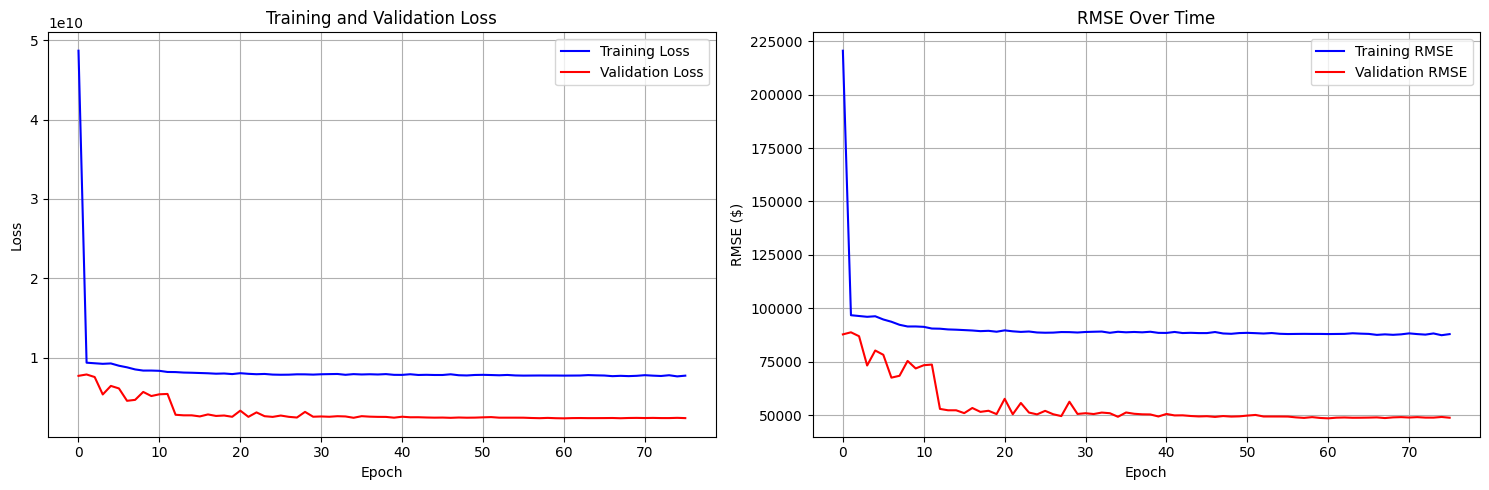

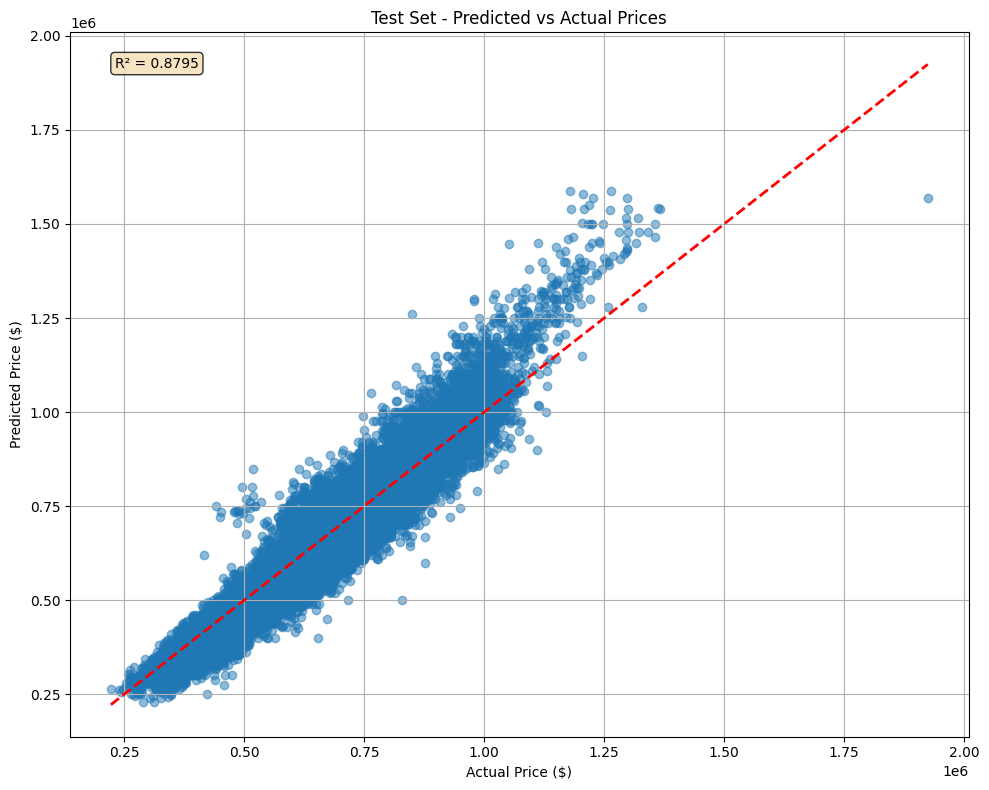

In [26]:
plot_training_curves(history)
plot_predictions(test_pred, test_true, "Test Set")